Pulses from  pulsars and FRBs are often many samples wide. 
To search for these pulses in a dedipersed stream of data, we must convolve the data stream with a 
shape that is similar to that of the pulse. 
We most often use a boxcar, a shape that has the same number for a continuous section, and is zero elsewhere. 
It looks like this: ___|̅̅̅|___

We convolve the boxcar with the time series and search for large peaks, 
if the peaks are above a threshold, we'll further analyze this section of data.

In this notebook, I make a pulse that is scatter broadened and then use boxcars from 2^0 to 2^14 to find the optimal signal to noise

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from pylab import figure, setp, show
from scipy.signal import boxcar

# plt.rc('text', usetex=True) #to LaTex the labels
# plt.rc('font', family='serif')
# plt.rcParams.update({'font.size': 18})

In [2]:
length = 30000  # length of data
noise = np.random.normal(loc=0.0, scale=1.0, size=length)  # zero mean, unit var

In [3]:
def pulse_maker(t, S, mu, simga, tau):
    """
    A Guassian pulse with an exponential tail

    Args:
        t: Array of time samples

        S: scaling factor of the pulse (proprtional to flux)

        mu: location of pulse

        sigma: with of the pulse

        tau: size of exponential tail

    Return:
        Array of intensities

    Refrence:
        M. M. McKinnon 2014 - https://arxiv.org/pdf/1404.6593.pdf
    """
    f = S / (simga * np.sqrt(2 * np.pi)) * np.exp(-1.0 / 2.0 * ((t - mu) / simga) ** 2)
    e = 1 / tau * np.exp(-t / tau) * np.heaviside(t - mu, 0)
    return f * e

In [4]:
line = np.linspace(0, length, num=length)  # line we will put th pulse in
pulse = pulse_maker(line, S=1e19, mu=length / 2, simga=400, tau=500)

Text(0, 0.5, 'Flux')

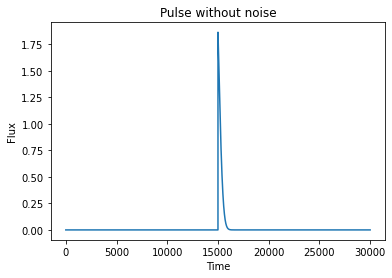

In [5]:
# looks good, can see the exponetial tail
plt.plot(pulse)
plt.title("Pulse without noise")
plt.xlabel("Time")
plt.ylabel("Flux")

In [6]:
time_series = pulse + noise  # the data we will want to process

Text(0, 0.5, 'FLux')

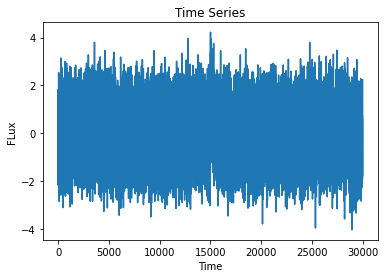

In [7]:
# Now its hard to see the pulse!
plt.plot(time_series)
plt.title("Time Series")
plt.xlabel("Time")
plt.ylabel("FLux")

In [8]:
box_cars = [2 ** x for x in range(0, 14)]  # will try boxcars from 2**0 to 2**14

In [9]:
num_box_cars = len(box_cars)
time_series_convolved = [None] * num_box_cars  # keep these for later
snrs = [None] * num_box_cars
kernals = [None] * num_box_cars

for j, car_length in enumerate(box_cars):
    kernal = np.array(boxcar(car_length) / car_length)  # kernal should be normalized
    kernals[j] = kernal
    time_series_convolved[j] = np.convolve(
        time_series, kernal, "valid"
    )  # only keep the valid data
    snrs[j] = np.max(time_series_convolved[j][14000:16000]) / np.std(
        time_series_convolved[j][:14000]
        # calculate the snr, make sure to get std off pulse and peak is on pulse
    )

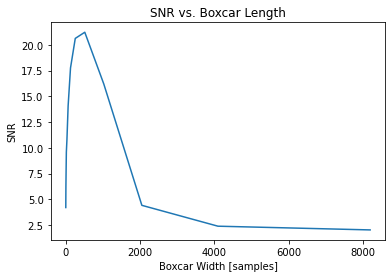

In [10]:
# can see the peak in SNRs
plt.title("SNR vs. Boxcar Length")
plt.xlabel("Boxcar Width [samples]")
plt.ylabel("SNR")
plt.plot(box_cars, snrs)

Location of max: 2**9


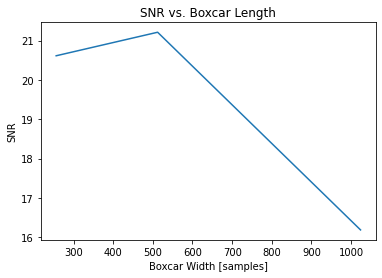

In [11]:
# Find the peak
plt.title("SNR vs. Boxcar Length")
plt.xlabel("Boxcar Width [samples]")
plt.ylabel("SNR")
# plt.plot(box_cars[:11], snrs[:11])
plt.plot(box_cars[8:11], snrs[8:11])
print(f"Location of max: 2**{snrs.index(max(snrs))}")

### some fancy formatting
"""params = {"ytick.color" : "w",#
		  "axes.labelcolor" : "w",
		  "axes.edgecolor" : "w",
		  "text.color":"w"}
plt.rcParams.update(params)"""

params = {"ytick.color" : "b",#
		  "axes.labelcolor" : "b",
		  "axes.edgecolor" : "b",
		  "text.color":"b"}
plt.rcParams.update(params)

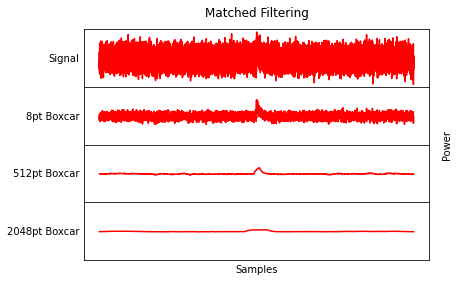

In [12]:
# make some plots of the time series convolved with boxcars
# so we can see how the SNR changes
# plot 1) signal 2) boxcar smaller than idea 3) boxcar @ max snr,
# 4) boxcar larger than ideal

fig = figure()
fig.suptitle("Matched Filtering")
yprops = dict(
    rotation=0, horizontalalignment="right", verticalalignment="center", x=-0.01
)

axprops = dict(yticks=[])

j = 3  # show these boxcar lengths
w = 9
k = 11

ax1 = fig.add_axes([0.1, 0.7, 0.8, 0.2], **axprops)
ax1.plot(time_series[2 ** k // 2 : -(2 ** k) // 2], color="r")
# we are only plotting valid numbers
# the larget boxcar will have 2*2**k points missing
# I'll cut this to make things look pretty
# ax1.set_ylim(-1,2)
ax1.set_ylabel("Signal", **yprops)
# ax1.text(-1, 0.5, f"{snrs[j]:.1f} SNR",  ha='center', va='center', rotation='vertical')
# makes it too complicated, make new plt

axprops["sharex"] = ax1
axprops["sharey"] = ax1

ax2 = fig.add_axes([0.1, 0.5, 0.8, 0.2], **axprops)
ax2.plot(
    time_series_convolved[j][(2 ** k - 2 ** j) // 2 : (-(2 ** k) + 2 ** j) // 2],
    color="r",
)
ax2.set_ylabel(f"{2**j}pt Boxcar", **yprops)

ax3 = fig.add_axes([0.1, 0.3, 0.8, 0.2], **axprops)
ax3.plot(
    time_series_convolved[w][(2 ** k - 2 ** w) // 2 : (-(2 ** k) + 2 ** w) // 2],
    color="r",
)
ax3.set_ylabel(f"{2**9}pt Boxcar", **yprops)

ax4 = fig.add_axes([0.1, 0.1, 0.8, 0.2], **axprops)
ax4.plot(time_series_convolved[k], color="r")
# ax4.set_ylim(-4,10)
ax4.set_ylabel(f"{2**k}pt Boxcar", **yprops)
ax4.set_xticks([])
plt.xlabel("Samples")
fig.text(0.94, 0.5, "Power", ha="center", va="center", rotation="vertical")

# turn off x ticklabel
for ax in ax1, ax2, ax3:
    setp(ax.get_xticklabels(), visible=False)
plt.savefig("matched_filter.png", dpi=300, bbox_inches="tight", transparent=True)

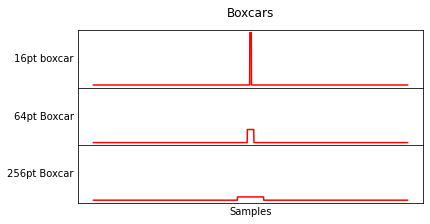

In [13]:
# Plot what the boxcars look like
# I chose three that fit togther nicely

fig = figure()
fig.suptitle("Boxcars")
yprops = dict(
    rotation=0, horizontalalignment="right", verticalalignment="center", x=-0.01
)

axprops = dict(yticks=[])
j = 4  # box car widths
w = 6
k = 8
num_zeros = 3072  # number of zeros to pad width

box_1 = np.zeros(num_zeros)
box_1[num_zeros // 2 - 2 ** j // 2 : num_zeros // 2 + 2 ** j // 2] = kernals[j]
ax1 = fig.add_axes([0.1, 0.7, 0.8, 0.2], **axprops)
ax1.plot(box_1, color="r")
ax1.set_ylabel(f"{2**j}pt boxcar", **yprops)

axprops["sharex"] = ax1
axprops["sharey"] = ax1

box_2 = np.zeros(num_zeros)
box_2[num_zeros // 2 - 2 ** w // 2 : num_zeros // 2 + 2 ** w // 2] = kernals[w]
ax2 = fig.add_axes([0.1, 0.5, 0.8, 0.2], **axprops)

ax2.plot(box_2, color="r")
ax2.set_ylabel(f"{2**w}pt Boxcar", **yprops)

box_3 = np.zeros(num_zeros)
box_3[num_zeros // 2 - 2 ** k // 2 : num_zeros // 2 + 2 ** k // 2] = kernals[k]
ax3 = fig.add_axes([0.1, 0.3, 0.8, 0.2], **axprops)
ax3.plot(box_3, color="r")
# ax3.set_ylim(-4,3)
ax3.set_ylabel(f"{2**k}pt Boxcar", **yprops)
ax3.set_xticks([])
plt.xlabel("Samples")

# turn off x ticklabels for all but the lower axes
for ax in ax1, ax2, ax3:
    setp(ax.get_xticklabels(), visible=False)
plt.savefig("boxcars.png", dpi=300, bbox_inches="tight", transparent=True)

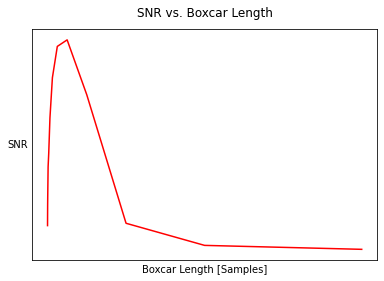

In [14]:
# make a nice plot of signal to noise vs boxcar length
fig = figure()
fig.suptitle("SNR vs. Boxcar Length")
yprops = dict(
    rotation=0, horizontalalignment="right", verticalalignment="center", x=-0.01
)

axprops = dict(yticks=[])
ax1 = fig.add_axes([0.1, 0.1, 0.8, 0.8], **axprops)

ax1.plot(box_cars, snrs, color="r")
ax1.set_ylabel("SNR", **yprops)
ax1.set_xticks([])

plt.xlabel("Boxcar Length [Samples]")

# turn off x ticklabels for all but the lower axes
setp(ax1.get_xticklabels(), visible=False)
plt.savefig("SNR.png", dpi=300, bbox_inches="tight", transparent=True)